# Exploratory Data Analysis: Image Sizes
The training and test images come in various sizes. They need to be normalized to a standard size before training a network on them.

It's not enough to just resize them all to a fixed size though, because they have very different aspect ratios.

The purpose of this notebook is to explore the range of aspect ratios and to get a sense for what kind of normalization is appropriate. A suggestion for how to normalize the images is described in the last cell. This will be implemented in a future notebook.

In [1]:
%matplotlib inline

from glob import glob
from ipywidgets import FloatProgress
from IPython.display import display
import os
import pickle
import re
import warnings

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import seaborn as sns

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [2]:
def natural_key(string_):
    """
    Define sort key that is integer-aware
    """
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]

## Create lists of paths to train/test data

In [3]:
TRAIN_DIR = 'data/train/'
TEST_DIR = 'data/test/'

train_cats = sorted(glob(os.path.join(TRAIN_DIR, 'cat*.jpg')), key=natural_key)
train_dogs = sorted(glob(os.path.join(TRAIN_DIR, 'dog*.jpg')), key=natural_key)
train_all = train_cats + train_dogs

test_all = sorted(glob(os.path.join(TEST_DIR, '*.jpg')), key=natural_key)

## Calculate sizes and aspect ratios

In [4]:
# Load cached data if available
path_sizes = 'sizes.pkl'
if os.path.isfile(path_sizes):
    with open(path_sizes, 'rb') as f:
        df_sizes = pickle.load(f)
else:
    prg = FloatProgress(min=0, max=len(train_all), bar_style = '', description='Accumulating sizes...')
    display(prg)
    aspr_all = []
    cols_all = []
    rows_all = []
    for idx, trn in enumerate(train_all):
        im = Image.open(trn)
        cols, rows = im.size
        cols_all.append(cols)
        rows_all.append(rows)
        aspr_all.append(cols / rows)
        prg.value = idx
    print('Done')

    # Put it into a dataframe
    df_sizes = pd.DataFrame.from_dict({'Path':train_all, 'Cols':cols_all, 'Rows':rows_all, 'AspRat':aspr_all})
    df_sizes = df_sizes[['Path', 'Cols', 'Rows', 'AspRat']]

    # Save it
    with open(path_sizes, 'wb') as f:
        pickle.dump(df_sizes, f)
    print('Size data saved to {}'.format(path_sizes))

## Some basic statistics

In [5]:
# Show some stuff
df_sizes.describe()

,Cols,Rows,AspRat
count,25000.00000,25000.000000,25000.000000
mean,404.09904,360.478080,1.157199
std,109.03793,97.019959,0.291914
min,42.00000,32.000000,0.306613
25%,323.00000,301.000000,0.929851
50%,447.00000,374.000000,1.270944
75%,499.00000,421.000000,1.336898
max,1050.00000,768.000000,5.909091


## Histogram of aspect ratios

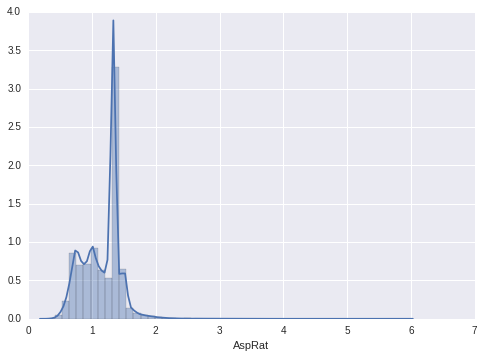

In [6]:
# Histrogram and KDE of aspect ratios
sns.distplot(df_sizes['AspRat']);

## Extreme aspect ratios

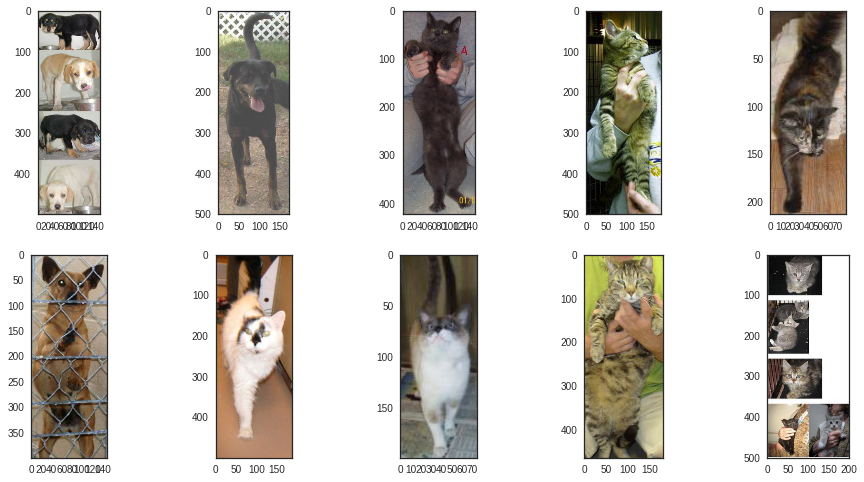

In [7]:
df_byaspr = df_sizes.sort_values('AspRat')
paths = df_byaspr.iloc[:10]['Path'].values
with sns.axes_style("white"):
    fig = plt.figure(figsize=(16,8))
    for col, path in enumerate(paths):
        plt.subplot(2, 5, col + 1)
        img = mpimg.imread(path)
        plt.imshow(img)

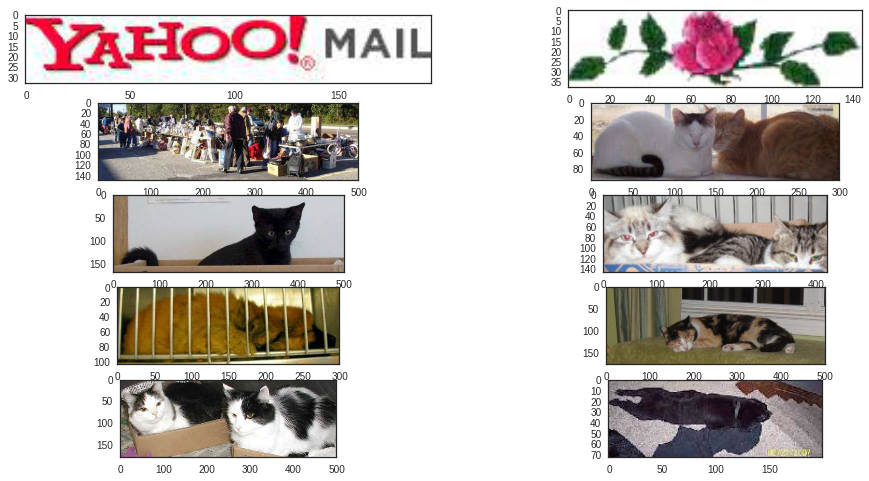

In [8]:
paths = df_byaspr.iloc[-10:]['Path'].values[::-1]
with sns.axes_style("white"):
    fig = plt.figure(figsize=(16,8))
    for col, path in enumerate(paths):
        plt.subplot(5, 2, col + 1)
        img = mpimg.imread(path)
        plt.imshow(img)

## Median aspect ratios

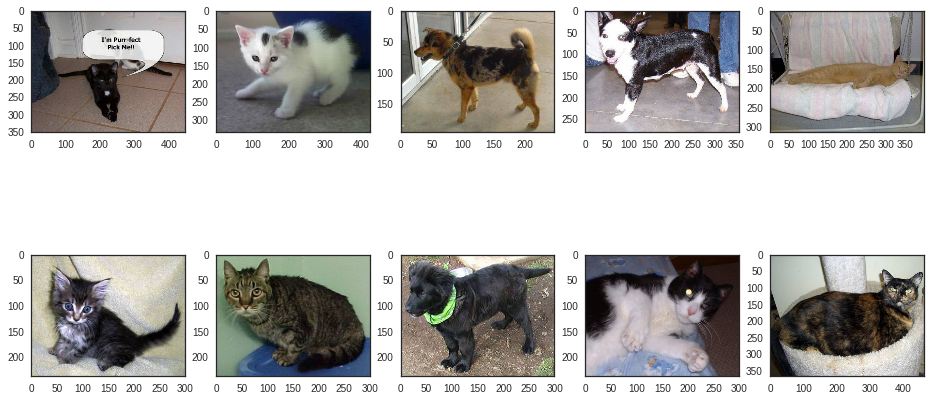

In [9]:
start = 12500 - 5
paths = df_byaspr.iloc[start:start + 10]['Path']
with sns.axes_style("white"):
    fig = plt.figure(figsize=(16,8))
    for col, path in enumerate(paths):
        plt.subplot(2, 5, col + 1)
        img = mpimg.imread(path)
        plt.imshow(img)

## Comments
There's a couple of obvious outliers, but they seem to few in number. So let's not worry about them.

We'd like the normalized images to be square, mostly for compatibility with models that are pretrained on ImageNet. But it is clear from some of the above that cropping to a square aspect ratio will lose valuable information. So instead we consider padding the images to be square.

A strategy for normalizing the images could be:

  1. Subtract the mean from each channel
  2. Stretch the range to [0.05, 0.95] percentiles
  3. Resize largest axis to desired side length (e.g., 224 for ImageNet compatibility)
  4. Change canvas size to make image square, using black as the fill color.
 
We will implement this in another notebook.